<a href="https://colab.research.google.com/github/r42arty/hse/blob/main/mod4/ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center> Практическое домашнее задание 3 </center>

*`credits to ML course by E. Sokolov`*

### Общая информация

Дата выдачи: 16.04.2025

Первый дедлайн: 07:59MSK 18.05.2025

Второй дедлайн: 07:59MSK 20.05.2025

### Оглавление

В этом задании вы:

1. [ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии](#введение)
2. [познакомитесь с калибровкой вероятности](#калибровка)
3. [изучите методы трансформации переменных и методы отбора признаков](#кодировка)
4. [попробуете оценить экономический эффект модели](#модель)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

**Штраф за каждый день просрочки мягкого дедлайна**: 0.5 баллов. После жесткого дедлайна работы не принимаются.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

❗️ Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо **указать ссылку на этот источник**.

**❗️ При использовании генеративных нейросетей:**

1. Необходимо указывать их как источник в каждом соответствующем задании
2. Ассистенты могут проводить мини-защиты ДЗ
3. Без указания как источника и подозрениях ассистентов, задания будут так же защищаться, иначе обнуляться.

# Часть 1. SVM, LR и калибровка вероятностей<a name="введение"></a>

*Максимум: 3 балла*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (1 балл)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
from sklearn.dummy import DummyClassifier


random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?

**Ваш Ответ**:

y_random содержит дробные значения (например, 0.5), потому что используется метод predict_proba, который возвращает вероятности классов.

В данном случае стратегия 'uniform' даёт равную вероятность для каждого класса, поэтому и получается 0.5.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


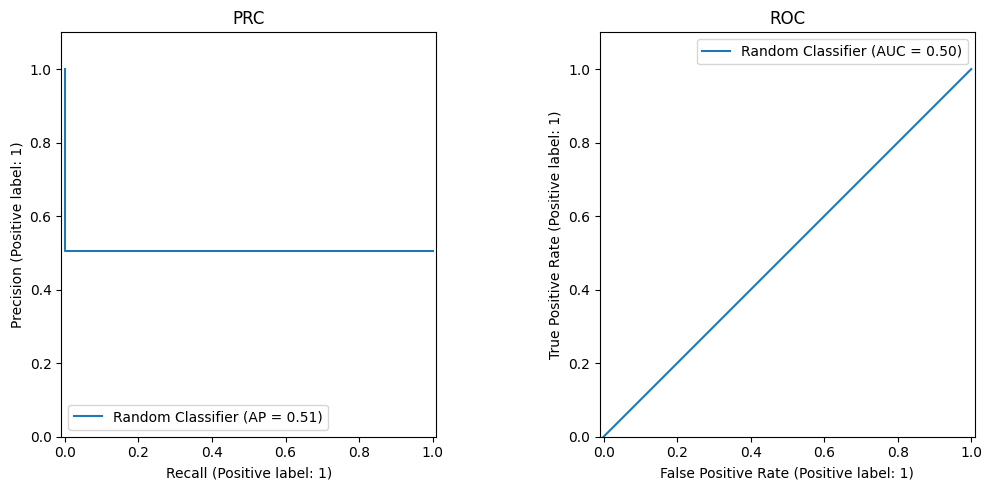

In [26]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [7]:
# DataFrame для сравнения методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)

# Добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score

C_value    = np.logspace(-2, 2, 10)
C_searcher = GridSearchCV(SVC(), {'C': C_value}, scoring='average_precision', cv=5, n_jobs=-1)
C_searcher.fit(X_train, y_train)

best_C   = C_searcher.best_params_['C']
svc_pred = C_searcher.decision_function(X_test) # предсказываем

print("Best C value: %.2f" % best_C)
print("SVC AUC-PR %.2f:" % average_precision_score(y_test, svc_pred))

Best C value: 100.00
SVC AUC-PR 0.98:


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

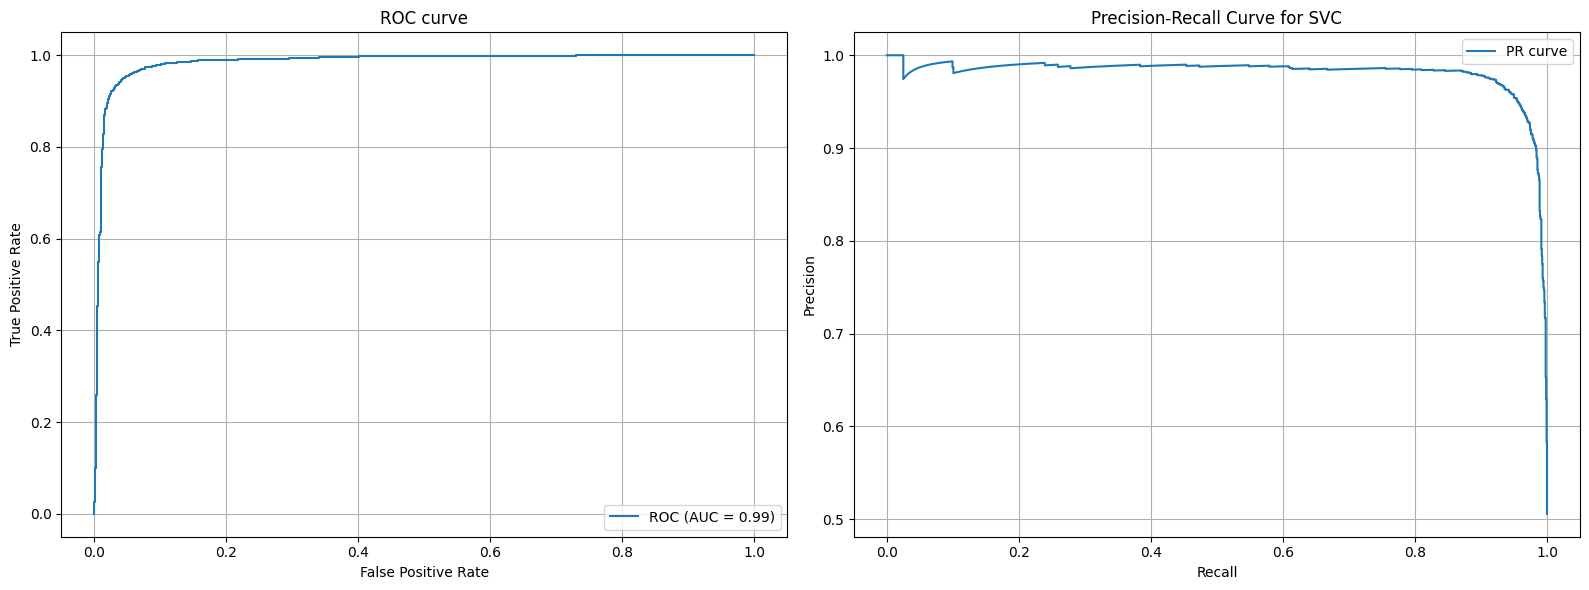

AUC-ROC: 0.98561
AUC-PR: 0.98141


In [23]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# ROC
fpr, tpr, _ = roc_curve(y_test, svc_pred)
roc_auc = auc(fpr, tpr)

# PR
precision, recall, _ = precision_recall_curve(y_test, svc_pred)

# Фигура с двумя подграфиками
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Первый график — ROC
axs[0].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
axs[0].set_title('ROC curve')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend()
axs[0].grid(True)

# Второй график — PR
axs[1].plot(recall, precision, label='PR curve')
axs[1].set_title('Precision-Recall Curve for SVC')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

auc_roc = roc_auc_score(y_test, svc_pred)

auc_pr = average_precision_score(y_test, svc_pred)

print(f"AUC-ROC: {auc_roc:.5f}")
print(f"AUC-PR: {auc_pr:.5f}")

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [24]:
positive_proportion = np.mean(y_test)

print(f"Доля положительных объектов в y_test (базовый AUC-PR): {positive_proportion:.5f}")

Доля положительных объектов в y_test (базовый AUC-PR): 0.50567


AUC-ROC (модель): 0.98561

AUC-PR (модель): 0.98141

Базовый AUC-PR (случайный классификатор): ≈ 0.50567 (доля положительных в y_test)

Модель существенно лучше случайного классификатора:
- ROC близок к 1 -- отличное разделение классов
- PR вдвое выше базового -- высокая точность при хорошем охвате

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [25]:
from sklearn.linear_model import LogisticRegression

C_vals = np.logspace(-2, 2, 10)

# GridSearchCV для LogisticRegression
gs = GridSearchCV(LogisticRegression(solver='liblinear', penalty='l2'), {'C': C_vals}, scoring='average_precision', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

best_C = gs.best_params_['C']
proba = gs.predict_proba(X_test)[:, 1]

print("Лучшее значение C для Logistic Regression: %.2f" % best_C)
print("AUC-PR Logistic Regression: %.2f" % average_precision_score(y_test, proba))

Лучшее значение C для Logistic Regression: 100.00
AUC-PR Logistic Regression: 0.83


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

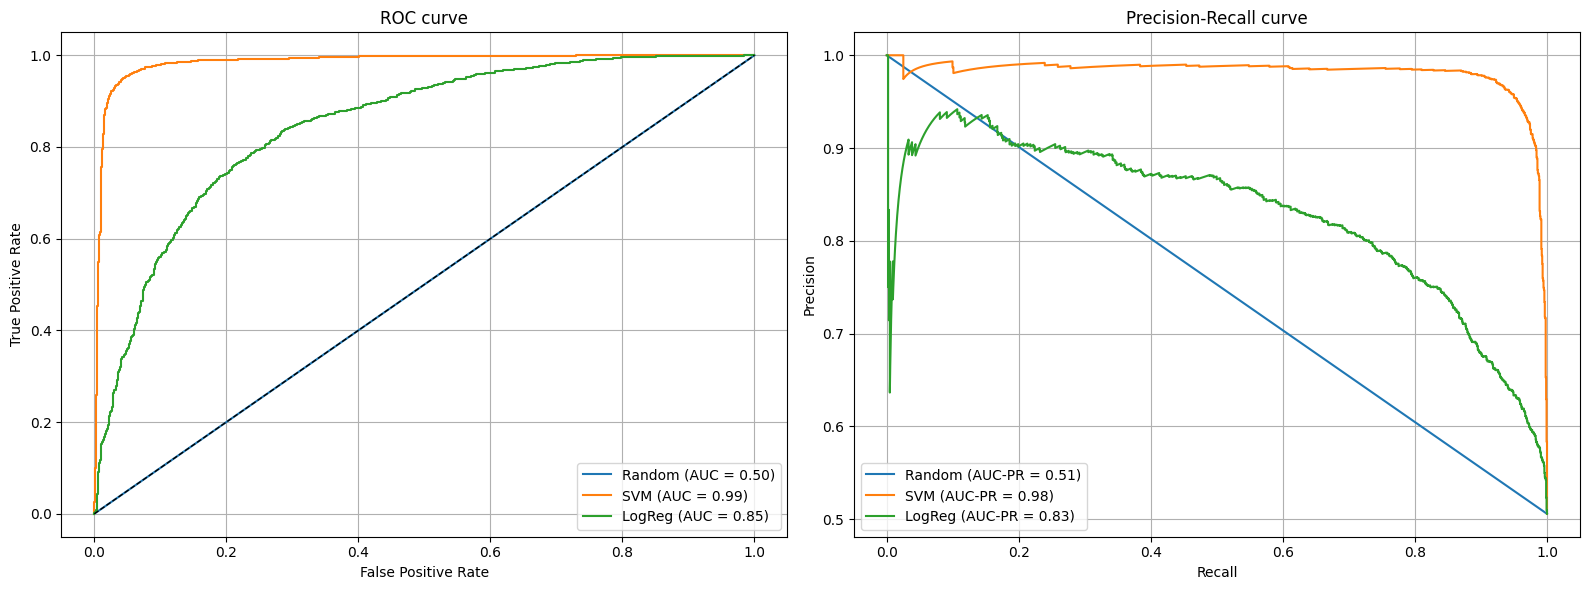

In [31]:
# ROC и PR-кривые + AUC/AUC-PR
def get_metrics(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    return fpr, tpr, auc(fpr, tpr), recall, precision, average_precision_score(y_true, y_score)

# Получение всех метрик
fpr_rand, tpr_rand, auc_rand, rec_rand, prec_rand, aucpr_rand = get_metrics(y_test, y_random)
fpr_svc,  tpr_svc,  auc_svc,  rec_svc,  prec_svc,  aucpr_svc  = get_metrics(y_test, svc_pred)
fpr_lr,   tpr_lr,   auc_lr,   rec_lr,   prec_lr,   aucpr_lr   = get_metrics(y_test, proba)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# ROC
axs[0].plot(fpr_rand, tpr_rand, label=f'Random (AUC = {auc_rand:.2f})')
axs[0].plot(fpr_svc,  tpr_svc,  label=f'SVM (AUC = {auc_svc:.2f})')
axs[0].plot(fpr_lr,   tpr_lr,   label=f'LogReg (AUC = {auc_lr:.2f})')
axs[0].plot([0, 1], [0, 1], 'k--', lw=1)
axs[0].set(title='ROC curve', xlabel='False Positive Rate', ylabel='True Positive Rate')
axs[0].legend()
axs[0].grid(True)

# PR
axs[1].plot(rec_rand, prec_rand, label=f'Random (AUC-PR = {aucpr_rand:.2f})')
axs[1].plot(rec_svc,  prec_svc,  label=f'SVM (AUC-PR = {aucpr_svc:.2f})')
axs[1].plot(rec_lr,   prec_lr,   label=f'LogReg (AUC-PR = {aucpr_lr:.2f})')
axs[1].set(title='Precision-Recall curve', xlabel='Recall', ylabel='Precision')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ваш Ответ:**

Модель SVM превосходит логистическую регрессию

AUC-ROC:
- SVM: 0.99
- LogReg: 0.85


SVM почти идеально разделяет классы, тогда как логрегрессия даёт более сглаженное разделение

AUC-PR:
- SVM: 0.98
- LogReg: 0.83


SVM с линейным ядром даёт более чёткую границу решений, особенно на синтетических данных с линейной разделимостью.

Логистическая регрессия более чувствительна к выбросам и может недообучиться на сложных границах.

Также SVM оптимизирует margin, что обеспечивает лучшее обобщение.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)  <a name="калибровка"></a>

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [33]:
X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)

SVC(kernel='linear')

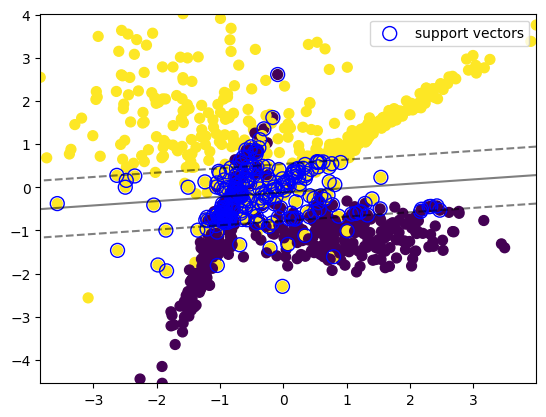

In [36]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы уже обученной модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку X
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.viridis)

    #Отрисовали опорные векторы
    if plot_support:
        support_vectors = model.support_vectors_
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, svc_model)

Заметим, что в неразделимых случаях опорные вектора - объекты нашей выборки - далеко не всегда оказываются на границах зазора.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [37]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

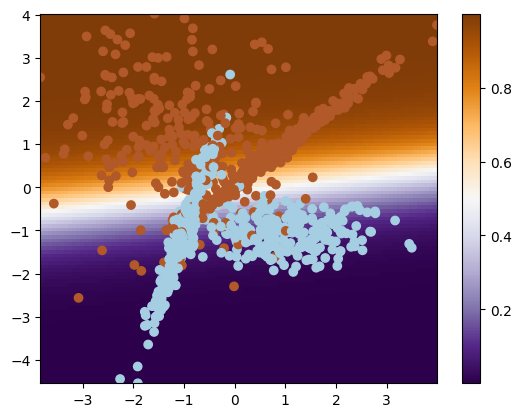

In [38]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, logreg_model)

#### __Задание 2. Калибровка вероятностей__ (1.5 балла)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной кривой используем следующий алгоритм:

- Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

- Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц.

- Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. **В ней допущено две ошибки — найдите и исправьте их.**

In [39]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l - r) / 2)
        bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [40]:
X, y = make_classification(n_samples=1000, n_features=10,
                           n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict_proba(X_test)[:, 1]

svc_model = SVC(kernel='linear', probability=True, random_state=42)
svc_model.fit(X_train, y_train)
svc_preds = svc_model.predict_proba(X_test)[:, 1]
svc_prds_normalized = svc_preds

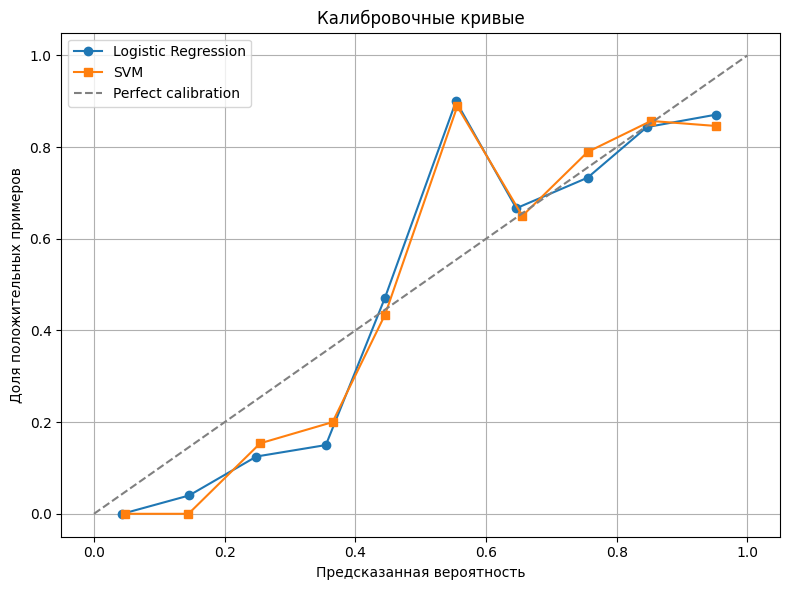

In [44]:
from sklearn.calibration import calibration_curve

# Получаем калибровочные кривые
prob_true_lr, prob_pred_lr = calibration_curve(y_test, lr_preds, n_bins=10, strategy='uniform')
prob_true_svc, prob_pred_svc = calibration_curve(y_test, svc_prds_normalized, n_bins=10, strategy='uniform')

# Рисуем график
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_lr, prob_true_lr, marker='o', label='Logistic Regression')
plt.plot(prob_pred_svc, prob_true_svc, marker='s', label='SVM')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Доля положительных примеров')
plt.title('Калибровочные кривые')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ваш Ответ:** Not great, not terrible

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

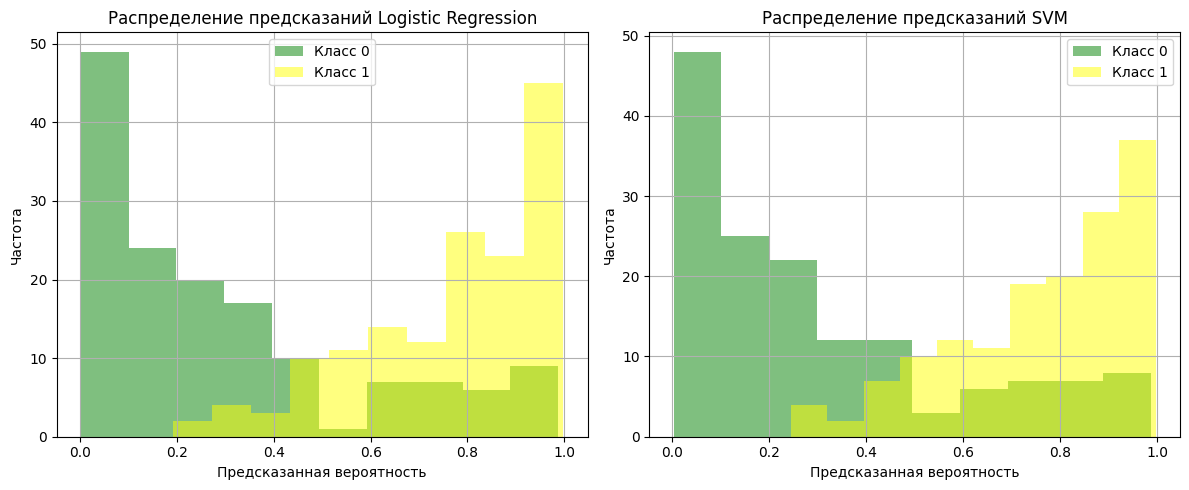

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма для Логистической Регрессии
ax1.hist(lr_preds[y_test == 0], bins=10, alpha=0.5, label='Класс 0', color='green')
ax1.hist(lr_preds[y_test == 1], bins=10, alpha=0.5, label='Класс 1', color='yellow')
ax1.set_title('Распределение предсказаний Logistic Regression')
ax1.set_xlabel('Предсказанная вероятность')
ax1.set_ylabel('Частота')
ax1.legend()
ax1.grid(True)

# Гистограмма для SVM
ax2.hist(svc_preds[y_test == 0], bins=10, alpha=0.5, label='Класс 0', color='green')
ax2.hist(svc_preds[y_test == 1], bins=10, alpha=0.5, label='Класс 1', color='yellow')
ax2.set_title('Распределение предсказаний SVM')
ax2.set_xlabel('Предсказанная вероятность')
ax2.set_ylabel('Частота')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ваш Ответ:**

- Logistic Regression предсказывает вероятности ближе к 0 и 1 (уверенные предсказания), но также оставляет значительное количество примеров в промежуточной зоне 0.4–0.6 — модель менее решительна на границе классов.
- SVM (после включения probability=True) даёт более сглаженное распределение и чаще предсказывает вероятности, близкие к границам 0 и 1 — особенно для класса 1. Видно меньше промежуточных значений, особенно в районе 0.5.

Причины:
- Логистическая регрессия напрямую оптимизирует вероятности и аппроксимирует логиты.
- SVM изначально не выдаёт вероятности — они получаются постобработкой (Platt scaling), которая может «сгладить» или «растянуть» распределение, особенно если граница между классами чёткая.

Вывод:
SVM делает более резкие предсказания, логрегрессия — более осторожные. Это влияет как на уверенность модели, так и на её калибровку.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html).

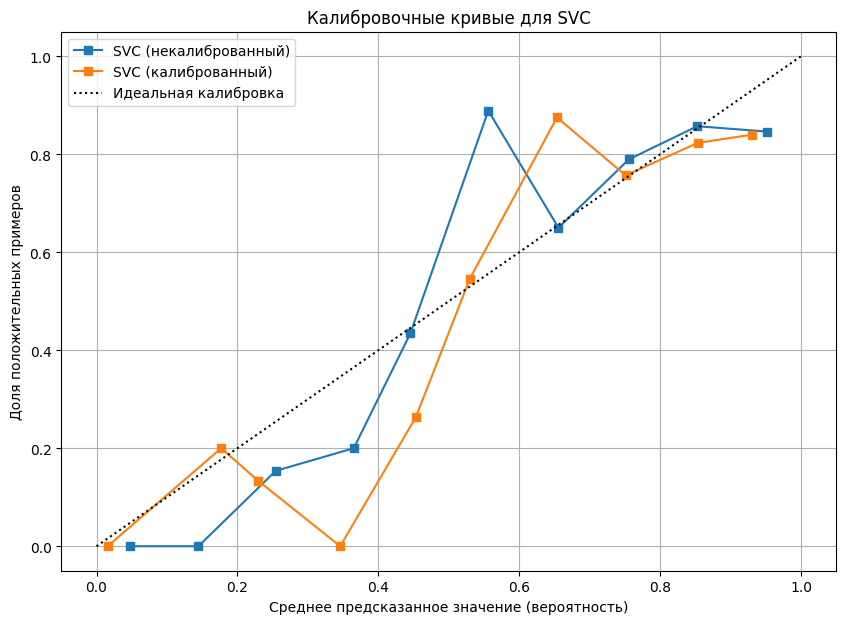

In [50]:
from sklearn.calibration import CalibratedClassifierCV

svc_calib = CalibratedClassifierCV(
    estimator=svc_model,
    method='isotonic'
)

svc_calib.fit(X_train, y_train)
svc_calib_probs = svc_calib.predict_proba(X_test)[:, 1]

frac_pos_raw, mean_pred_raw = calibration_curve(
    y_test, svc_preds, n_bins=10, strategy='uniform'
)

frac_pos_cal, mean_pred_cal = calibration_curve(
    y_test, svc_calib_probs, n_bins=10, strategy='uniform'
)

plt.figure(figsize=(10, 7))
plt.plot(mean_pred_raw, frac_pos_raw, "s-", label="SVC (некалиброванный)")
plt.plot(mean_pred_cal, frac_pos_cal, "s-", label="SVC (калиброванный)")
plt.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")
plt.xlabel("Среднее предсказанное значение (вероятность)")
plt.ylabel("Доля положительных примеров")
plt.title("Калибровочные кривые для SVC")
plt.legend()
plt.grid(True)
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ваш Ответ:** Скорее ухудшилась

# Часть 2. Обработка категориальных переменных  <a name="кодировка"></a>


*Максимум: 6 баллов*

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед

- Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

- Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [53]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("heeraldedhia/bike-buyers")

print("Path to dataset files:", path)

100%|██████████| 22.2k/22.2k [00:00<00:00, 15.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/heeraldedhia/bike-buyers/versions/2


In [55]:
import os

csv_path = os.path.join(path, "bike_buyers.csv")
df = pd.read_csv(csv_path)

df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [58]:
# Разделим на категориальные признаки и числовые
X_numerical   = ['ID', 'Income', 'Children', 'Cars', 'Age']
X_categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

#Заменим пропуски категориальных переменных
df[X_categorical] = df[X_categorical].fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

__Задание 2.1 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Что означает этот аргумент?

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

`stratify` означает одинаковое распределение классов в обучающей и тестовой выборке

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

* Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии.

* Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__:

In [70]:
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('clf', LogisticRegression(random_state=777, max_iter=1000))
])

X_train_cat = X_train[X_categorical]
X_test_cat = X_test[X_categorical]

start_timer = time.time()
pipeline.fit(X_train_cat, y_train)
train_time = time.time() - start_timer

y_pred_proba = pipeline.predict_proba(X_test_cat)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"AUC-PR: {auc_pr:.2f}")
print(f"Время обучения (с кодированием): {train_time:.2f} секунд")

AUC-PR: 0.59
Время обучения (с кодированием): 0.32 секунд


AUC-PR лучше подходит для задач с несбалансированными классами и более точно отражает качество предсказания редкого (положительного) класса, в то время как AUC-ROC может быть завышен за счёт большого числа объектов отрицательного класса.

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [72]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', drop='first')
clf = LogisticRegression(random_state=777, max_iter=1000)

X_train_cat = X_train[X_categorical]
X_test_cat = X_test[X_categorical]
start = time.time()
enc.fit(X_train_cat)
X_tr_enc = enc.transform(X_train_cat)
X_te_enc = enc.transform(X_test_cat)
clf.fit(X_tr_enc, y_train)
t = time.time() - start

y_pred = clf.predict_proba(X_te_enc)[:, 1]
auc = average_precision_score(y_test, y_pred)

print(f"AUC-PR (OneHotEncoder): {auc:.2f}")
print(f"Время кодирования и обучения (OneHotEncoder): {t:.2f} секунд")

AUC-PR (OneHotEncoder): 0.67
Время кодирования и обучения (OneHotEncoder): 0.16 секунд


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (2 балла)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [73]:
from sklearn.metrics import average_precision_score

start = time.time()

X_train_cat = X_train[X_categorical].copy()
X_test_cat = X_test[X_categorical].copy()
mean = y_train.mean()

for c in X_categorical:
    m = y_train.groupby(X_train[c]).mean()
    X_train_cat[c] = X_train[c].map(m)
    t = X_test[c].map(m)
    X_test_cat[c] = t.fillna(mean)

model = LogisticRegression(random_state=777, max_iter=1000)
model.fit(X_train_cat, y_train)
t_total = time.time() - start

y_pred = model.predict_proba(X_test_cat)[:, 1]
auc = average_precision_score(y_test, y_pred)

print(f"AUC-PR (Mean-Target Encoding): {auc:.2f}")
print(f"Время кодирования и обучения (Mean-Target Encoding): {t_total:.2f} секунд")

AUC-PR (Mean-Target Encoding): 0.66
Время кодирования и обучения (Mean-Target Encoding): 0.14 секунд


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [74]:
start = time.time()
noise = 0.01

X_train_cat = X_train[X_categorical].copy()
X_test_cat = X_test[X_categorical].copy()
mean = y_train.mean()

for c in X_categorical:
    m = y_train.groupby(X_train[c]).mean()
    X_train_cat[c] = X_train[c].map(m) + np.random.normal(0, noise, size=X_train.shape[0])
    t = X_test[c].map(m)
    X_test_cat[c] = t.fillna(mean) + np.random.normal(0, noise, size=X_test.shape[0])

model = LogisticRegression(random_state=777, max_iter=1000)
model.fit(X_train_cat, y_train)
t_total = time.time() - start

y_pred = model.predict_proba(X_test_cat)[:, 1]
auc = average_precision_score(y_test, y_pred)

print(f"AUC-PR (Mean-Target Encoding + Noise): {auc:.2f}")
print(f"Время кодирования и обучения (Mean-Target Encoding + Noise): {t_total:.2f} секунд")

AUC-PR (Mean-Target Encoding + Noise): 0.64
Время кодирования и обучения (Mean-Target Encoding + Noise): 0.04 секунд


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ваш Ответ:**

Добавление шума не помогло — качество модели снизилось

При хорошем объёме данных и корректной кодировке категориальных признаков (mean-target encoding), модель уже обобщает достаточно хорошо.
Добавление шума в таком случае вносит лишнюю вариативность, мешающую выявлять устойчивые зависимости.

Шум полезен как регуляризация при высоком риске переобучения, но в этом примере — ухудшил результат.

#### __Задание 7. Сглаживание счетчиков__  (1.5 балла)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Постарайтесь подобрать $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [75]:
def mean_target_encoding_smooth(X_train, y_train, X_test, categorical_features, C, prior=None, random_state=777, noise=0.01):
    if prior is None:
        prior = y_train.mean()
    X_train_enc = X_train.copy()
    X_test_enc = X_test.copy()
    np.random.seed(random_state)
    for col in categorical_features:
        stats = y_train.groupby(X_train[col]).agg(['mean', 'count'])
        smooth = (stats['mean'] * stats['count'] + C * prior) / (stats['count'] + C)
        X_train_enc[col] = X_train[col].map(smooth) + np.random.normal(0, noise, size=len(X_train))
        X_test_enc[col] = X_test[col].map(smooth).fillna(prior) + np.random.normal(0, noise, size=len(X_test))
    return X_train_enc, X_test_enc

best_auc = 0
best_C = None
for C in [1, 3, 5, 10, 20, 50, 100]:
    start = time.time()
    X_train_cat, X_test_cat = mean_target_encoding_smooth(
        X_train[X_categorical], y_train, X_test[X_categorical], X_categorical, C
    )
    model = LogisticRegression(random_state=777, max_iter=1000)
    model.fit(X_train_cat, y_train)
    y_pred = model.predict_proba(X_test_cat)[:, 1]
    auc = average_precision_score(y_test, y_pred)
    if auc > best_auc:
        best_auc = auc
        best_C = C
    print(f"C={C}, AUC-PR={auc:.2f}, время={time.time()-start:.2f} сек")

print(f"Лучшее C: {best_C}, лучший AUC-PR: {best_auc:.2f}")

C=1, AUC-PR=0.65, время=0.13 сек
C=3, AUC-PR=0.66, время=0.09 сек
C=5, AUC-PR=0.66, время=0.10 сек
C=10, AUC-PR=0.67, время=0.15 сек
C=20, AUC-PR=0.67, время=0.16 сек
C=50, AUC-PR=0.66, время=0.05 сек
C=100, AUC-PR=0.64, время=0.04 сек
Лучшее C: 20, лучший AUC-PR: 0.67


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [77]:
X_train_num = X_train[X_numerical].copy()
X_test_num = X_test[X_numerical].copy()
for col in X_numerical:
    mean_value = X_train_num[col].mean()
    X_train_num[col] = X_train_num[col].fillna(mean_value)
    X_test_num[col] = X_test_num[col].fillna(mean_value)

X_train_cat, X_test_cat = mean_target_encoding_smooth(
    X_train[X_categorical], y_train, X_test[X_categorical], X_categorical, best_C
)

X_train_full = np.hstack([X_train_num.values, X_train_cat.values])
X_test_full = np.hstack([X_test_num.values, X_test_cat.values])

model = LogisticRegression(random_state=777, max_iter=10000)
model.fit(X_train_full, y_train)
y_pred = model.predict_proba(X_test_full)[:, 1]
auc = average_precision_score(y_test, y_pred)
print(f"AUC-PR (числовые + mean-target encoding): {auc:.2f}")

AUC-PR (числовые + mean-target encoding): 0.71


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

# Часть 3. Оценка экономического эффекта модели  <a name="модель"></a>


*Максимум: 4 балла*

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что:

- выручка — это сколько денег нам принесли клиенты
- прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (2 балла)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [78]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2025-05-18 07:45:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [ <=>                ] 434.15K  --.-KB/s    in 0.1s    

2025-05-18 07:45:02 (3.17 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [79]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [80]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [82]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=500)
splits = list(kf.split(X))  # Получаем список из 5 пар (train_index, test_index)

* Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

* Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
  - Сколько денег вы в среднем заработаете?
  - Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Определяем числовые и категориальные признаки
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Препроцессор: стандартизация числовых и one-hot для категориальных
clf = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Pipeline: препроцессор + логистическая регрессия
pipeline = Pipeline([
    ('preprocessor', clf),
    ('classifier', LogisticRegression())
])

profit, costs = [], []

for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Считаем выручку и затраты
    calls = y_pred.sum()  # количество звонков (всем с положительным прогнозом)
    revenue = ((y_pred == 1) & (y_test == 1)).sum() * 10  # 10$ за каждого согласившегося
    cost = calls * 1  # 1$ за каждый звонок

    profit.append(revenue)
    costs.append(cost)

print('Выручка: %.2f' % np.mean(profit))
print('Отклонение выручки: %.2f' % np.std(profit))
print('Траты: %.2f' % np.mean(costs))
print('Прибыль: %.2f' % np.mean(np.array(profit)-np.array(costs)))
print('Отклонение прибыли %.2f' % np.std(np.array(profit) - np.array(costs)))

Выручка: 2128.00
Отклонение выручки: 91.96
Траты: 322.20
Прибыль: 1805.80
Отклонение прибыли 95.30


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [88]:
rng = np.random.default_rng()  # Новый генератор случайных чисел

profit_random, costs_random = [], []

for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Индексы клиентов, которым позвонили и которые согласились
    agreed = ((y_pred == 1) & (y_test == 1)).values
    # Случайная выручка для каждого согласившегося клиента
    revenue = rng.uniform(0, 20, size=agreed.sum()).sum()
    cost = y_pred.sum() * 1  # 1$ за каждый звонок

    profit_random.append(revenue)
    costs_random.append(cost)

print('Выручка (случайная): %.2f' % np.mean(profit_random))
print('Отклонение выручки: %.2f' % np.std(profit_random))
print('Траты: %.2f' % np.mean(costs_random))
print('Прибыль: %.2f' % np.mean(np.array(profit_random)-np.array(costs_random)))
print('Отклонение прибыли: %.2f' % np.std(np.array(profit_random) - np.array(costs_random)))

Выручка (случайная): 2166.35
Отклонение выручки: 130.61
Траты: 322.20
Прибыль: 1844.15
Отклонение прибыли: 128.40


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

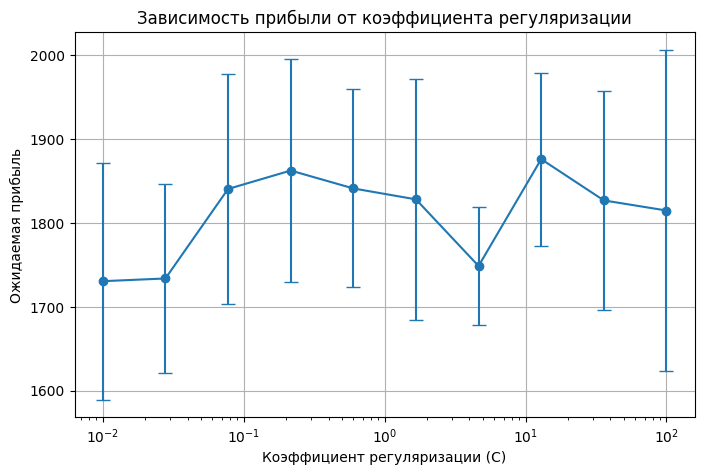

Максимальная прибыль: 1875.91 ± 103.11
Лучший коэффициент регуляризации: 12.9


In [94]:
reg_consts = np.logspace(-2, 2, 10)
mean_profits, std_profits = [], []

for C in reg_consts:
    profits = []
    for train_index, test_index in splits:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Новый pipeline с нужным коэффициентом регуляризации
        pipeline = Pipeline([
            ('preprocessor', clf),
            ('classifier', LogisticRegression(C=C, max_iter=1000))
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        agreed = ((y_pred == 1) & (y_test == 1)).values
        revenue = rng.uniform(0, 20, size=agreed.sum()).sum()
        cost = y_pred.sum()
        profits.append(revenue - cost)
    mean_profits.append(np.mean(profits))
    std_profits.append(np.std(profits))

# График зависимости прибыли от коэффициента регуляризации
plt.figure(figsize=(8, 5))
plt.errorbar(reg_consts, mean_profits, yerr=std_profits, fmt='-o', capsize=5)
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Ожидаемая прибыль')
plt.title('Зависимость прибыли от коэффициента регуляризации')
plt.grid(True)
plt.show()

best_idx = np.argmax(mean_profits)
print(f'Максимальная прибыль: {mean_profits[best_idx]:.2f} ± {std_profits[best_idx]:.2f}')
print(f'Лучший коэффициент регуляризации: {reg_consts[best_idx]:.3g}')

#### __Задание 13. Ключевая метрика__ (2 балла)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Важен precision, показывающий как предсказвть какой клиент согласится на кредит.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [101]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 5)
mean_precisions, mean_recalls, mean_profits = [], [], []

for thresh in thresholds:
    precisions, recalls, profits = [], [], []
    for train_index, test_index in splits:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= thresh).astype(int)

        # Метрики
        if y_pred.sum() > 0:
            precisions.append(precision_score(y_test, y_pred))
        else:
            precisions.append(np.nan)
        recalls.append(recall_score(y_test, y_pred))

        agreed = ((y_pred == 1) & (y_test == 1)).values
        revenue = rng.uniform(0, 20, size=agreed.sum()).sum()
        cost = y_pred.sum()
        profits.append(revenue - cost)
    mean_precisions.append(np.nanmean(precisions))
    mean_recalls.append(np.mean(recalls))
    mean_profits.append(np.mean(profits))

# Пример: ищем максимальную прибыль при precision >= 0.5
for t, p, pr in zip(thresholds, mean_precisions, mean_profits):
    if p >= 0.5:
        print(f'Порог: {t:.2f}, Precision: {p:.2f}, Ожидаемая прибыль: {pr:.2f}')
        break

Порог: 0.50, Precision: 0.66, Ожидаемая прибыль: 1784.13


<ipython-input-101-67650677bc81>:27: RuntimeWarning: Mean of empty slice
  mean_precisions.append(np.nanmean(precisions))


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




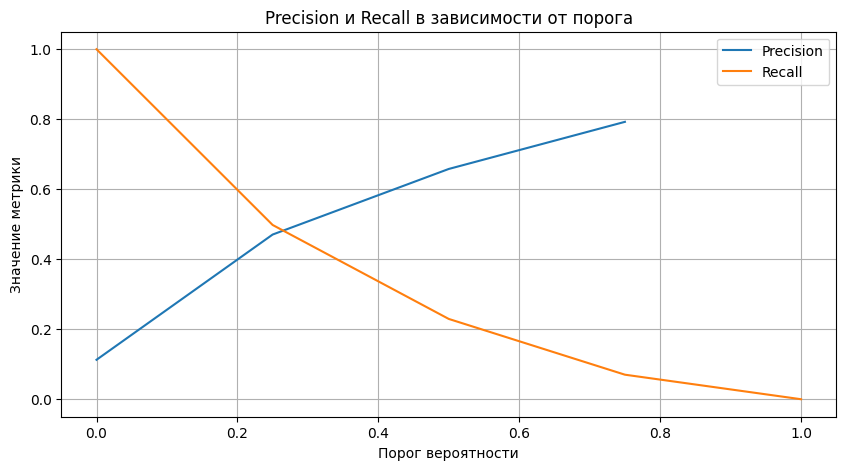

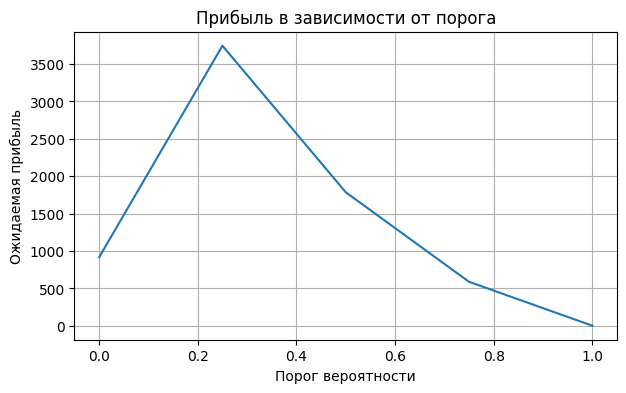

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, mean_precisions, label='Precision')
plt.plot(thresholds, mean_recalls, label='Recall')
plt.xlabel('Порог вероятности')
plt.ylabel('Значение метрики')
plt.title('Precision и Recall в зависимости от порога')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(thresholds, mean_profits, label='Ожидаемая прибыль')
plt.xlabel('Порог вероятности')
plt.ylabel('Ожидаемая прибыль')
plt.title('Прибыль в зависимости от порога')
plt.grid(True)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Есть закономерность -- Алгоритм максимизирует прибыль при ограничении по precision, а оптимум часто находится в области, где precision остаётся ≥ 0.5, но recall ещё не сильно упал

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [103]:
# Пусть выбранный порог — threshold_opt (например, 0.32)
threshold_opt = 0.32

precisions, recalls = [], []

for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold_opt).astype(int)

    if y_pred.sum() > 0:
        precisions.append(precision_score(y_test, y_pred))
    else:
        precisions.append(np.nan)
    recalls.append(recall_score(y_test, y_pred))

print(f'Precision: {np.nanmean(precisions):.3f} ± {np.nanstd(precisions):.3f}')
print(f'Recall: {np.mean(recalls):.3f} ± {np.std(recalls):.3f}')

Precision: 0.501 ± 0.027
Recall: 0.413 ± 0.019
